In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics

In [ ]:
df = pd.read_csv("dataset/fitness_class_2212.csv")

**DATA CLEANING**

In [ ]:
#Data cleaning phase, formatting/cleaning the data to be "schematic"
#Filling the 'weight' column with the mean of the values
df["weight"] = df["weight"].fillna(df["weight"].mean())

In [ ]:
#Some of the data contains the string "days", but the "days_before" column is composed as integer
#Here I'm deleting the "days" word, and converting the values into int
df["days_before"] = df["days_before"].str.replace(" days","")
df["days_before"] = df["days_before"].astype(int)

In [ ]:
#Some inconsistency in the data
df['day_of_week'] = df['day_of_week'].str[:3]

day_mapping = {
    'Mon': 1,
    'Tue': 2,
    'Wed': 3,
    'Thu': 4,
    'Fri': 5,
    'Sat': 6,
    'Sun': 7
}

df['day_of_week'] = df['day_of_week'].map(day_mapping)

In [ ]:
#Some of the elements in the "category" column is "-", I'm replacing it with "unknown" 
df['category'] = df['category'].str.replace("-","unknown")

category_mapping = {
    "Aqua": 0,
    "unknown": 1,
    "Cycling": 2,
    "HIIT": 3,
    "Strength": 4,
    "Yoga": 5
}

df['category'] = df['category'].map(category_mapping)
df['category'] = df['category'].astype(int)

In [ ]:
#Mapping the time column too
time_mapping = {
    "AM": 0,
    "PM": 1
}

df['time'] = df['time'].map(time_mapping)
df['time'] = df['time'].astype(int)

**PLOTS**

In [ ]:
category_counts = df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
category_counts = category_counts.sort_values(by='count', ascending=False)

plt.figure(figsize =(10,6))

ax = sns.countplot(data=df, x='category', hue='attended', order=category_counts['category'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Attendance by Category')
plt.legend(title='Attended', labels=['Not Attended', 'Attended'])
plt.savefig('graphs/Count of Attendace by Category.png')
plt.show()

In [ ]:
cross_tab = pd.crosstab(df['category'], df['attended'], normalize='index') * 100

# Create a heatmap using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='.1f', cbar=False)
plt.xlabel('Attended')
plt.ylabel('Category')
plt.title('Percentage of Attendance by Category')
plt.savefig('graphs/Percentage of Attendance by Category')
plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='months_as_member',kde=True)
plt.title('Distribution of the number of months as a member')
plt.savefig('graphs/Distribution of the number of months as a member')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x=np.log1p(df['months_as_member']), kde=True)
plt.xlabel('Log-transformed Months as Member')
plt.tight_layout()
plt.savefig('graphs/Log-transformed Months as Member')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='attended', y='months_as_member', orient='v')
plt.xlabel('Number of Months as a Member')
plt.ylabel('Attendance')
plt.title('Relationship between Attendance and Number of Months (With Outliers)')
plt.grid(True)
plt.savefig('graphs/Relationship between Attendance and Number of Months (With Outliers)')
plt.show()

**REMOVING OUTLIERS**

In [ ]:
#Removing Outliers
Q1 = df["months_as_member"].quantile(0.25)
Q3 = df["months_as_member"].quantile(0.75)
IQR = Q3 - Q1

#Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

new_df = df[(df['months_as_member'] >= lower_bound) & (df['months_as_member'] <= upper_bound)]

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=new_df, x='attended', y='months_as_member', orient='v')
plt.xlabel('Number of Months as a Member')
plt.ylabel('Attendance')
plt.title('Relationship between Attendance and Number of Months (Without Outliers)')
plt.grid(True)
plt.savefig('graphs/Relationship between Attendance and Number of Months (Without Outliers)')
plt.show()

In [ ]:
X = new_df.drop(columns=['attended', 'booking_id'],axis=1)
y = new_df["attended"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

**LOGISTIC REGRESSION**

In [ ]:
#Default model
lr_def = LogisticRegression(max_iter=400)

#Penalized
lr_pen = LogisticRegression(C=0.3, max_iter=200, penalty='l1', solver='liblinear')
lr_pen1 = LogisticRegression(C=0.1, max_iter=200 ,penalty='l2', solver='lbfgs')

In [ ]:
#Model fitting
lr_def.fit(X_train, y_train)
lr_pen.fit(X_train, y_train)
lr_pen1.fit(X_train, y_train)

**RANDOM FOREST CLASSIFIER**

In [ ]:
#Default model
rfcla_def = RandomForestClassifier()

#Modified params
rfcla_mod1 = RandomForestClassifier(n_estimators=200 ,max_depth=10, min_samples_split=2, 
                                    min_samples_leaf=1, max_features="log2", random_state=100)
rfcla_mod2 = RandomForestClassifier(n_estimators=100 ,max_depth=10, min_samples_split=2, 
                                    min_samples_leaf=1, max_features="sqrt", random_state=100)

In [ ]:
#Model fitting
rfcla_def.fit(X_train, y_train)
rfcla_mod1.fit(X_train, y_train)
rfcla_mod2.fit(X_train, y_train)

**GridSearchCV Models**

In [ ]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()

param_grid = {
    'C': [0.1, 0.3, 0.5, 1, 5, 10],
    'max_iter': [100, 150, 200, 500],
    'penalty':['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

gridsearch_lr_model = grid_search.best_estimator_

print("Best Parameters for Logistic Regression: ", grid_search.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search.best_score_))
print("Model score: ", gridsearch_lr_model.score(X_test, y_test))

In [ ]:
rf_classifier = RandomForestClassifier()

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2],
    'random_state':[1, 42, 100]
}

grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5, scoring='accuracy')

grid_search_rf.fit(X_train, y_train)

gridsearch_rfcla_model = grid_search_rf.best_estimator_

print("Best Parameters for Random Forest Classifier: ", grid_search_rf.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(grid_search_rf.best_score_))
print("Model score: ", gridsearch_rfcla_model.score(X_test, y_test))

**EVALUATIONS**

Logistic Regression score: 0.8
Precision: 0.603448275862069
Recall: 0.3645833333333333
F1-Score: 0.4545454545454546


Logistic Regression (Penalized L1) score: 0.8071428571428572
Precision: 0.631578947368421
Recall: 0.375
F1-Score: 0.47058823529411764


Logistic Regression (Penalized L2) score: 0.7976190476190477
Precision: 0.5964912280701754
Recall: 0.3541666666666667
F1-Score: 0.4444444444444445


Logistic Regression (GridSearchCV Model) score: 0.8047619047619048
Precision: 0.6206896551724138
Recall: 0.375
F1-Score: 0.4675324675324676


Random Forest Classifier score: 0.75
Precision: 0.4457831325301205
Recall: 0.3854166666666667
F1-Score: 0.41340782122905023


Random Forest Classifier (Modified features 1) score: 0.7714285714285715
Precision: 0.5
Recall: 0.3854166666666667
F1-Score: 0.43529411764705883


Random Forest Classifier (Modified features 2) score: 0.7833333333333333
Precision: 0.5333333333333333
Recall: 0.4166666666666667
F1-Score: 0.46783625730994155


Random Forest Classi

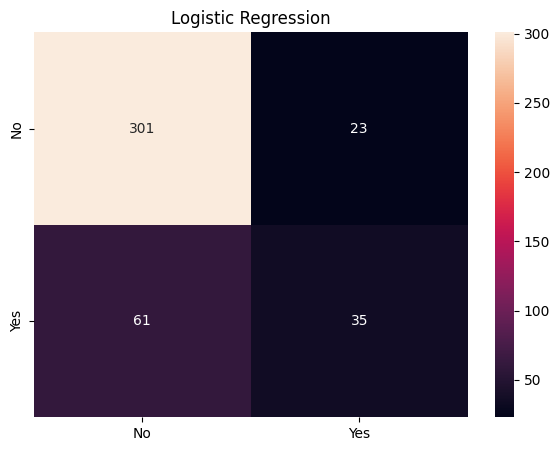

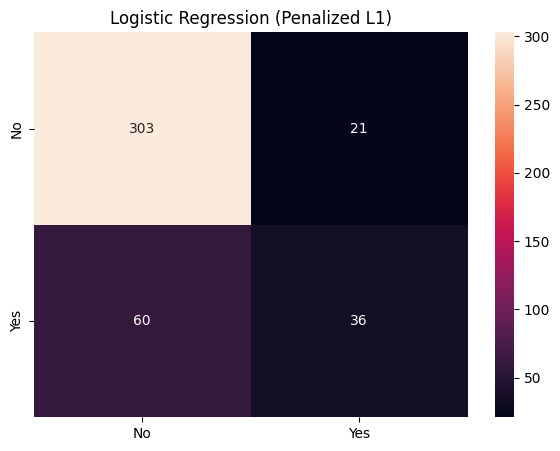

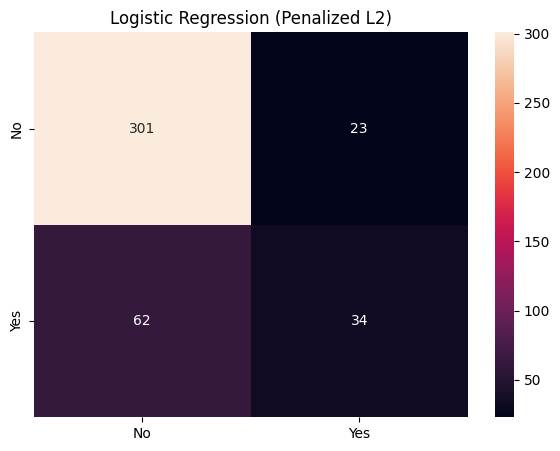

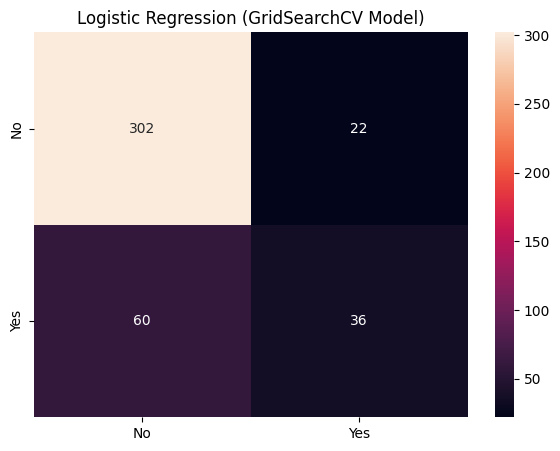

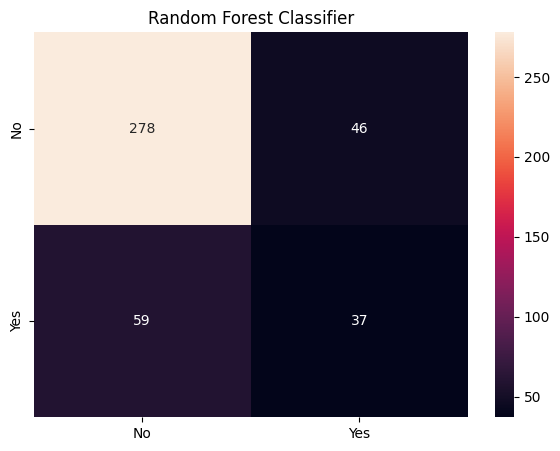

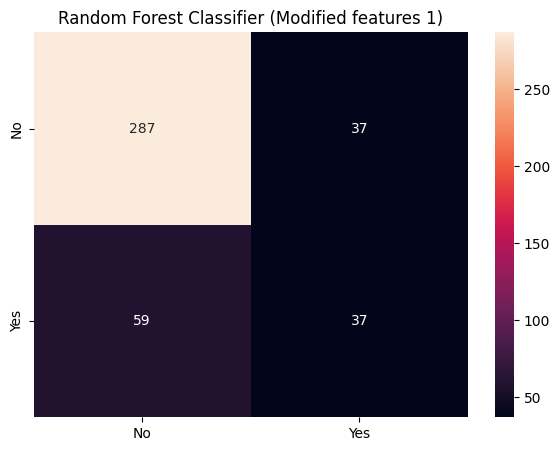

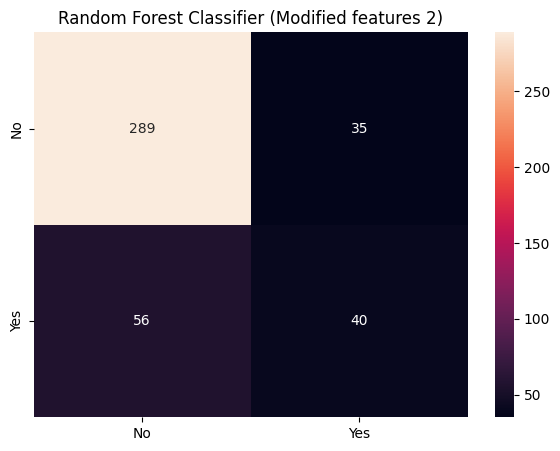

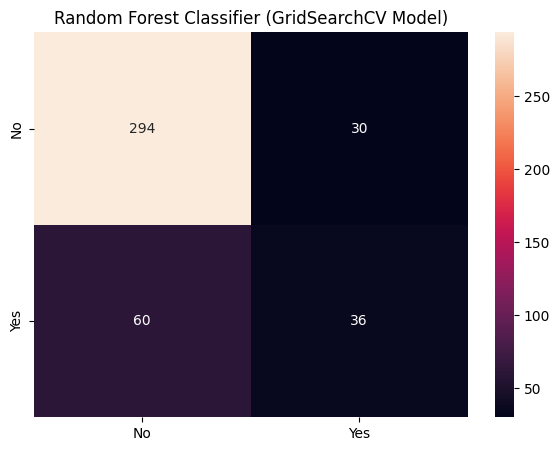

In [32]:
models = [lr_def, lr_pen, lr_pen1, gridsearch_lr_model, rfcla_def, rfcla_mod1, rfcla_mod2, gridsearch_rfcla_model]
model_names = ["Logistic Regression",
               "Logistic Regression (Penalized L1)", 
               "Logistic Regression (Penalized L2)",
               "Logistic Regression (GridSearchCV Model)",
               "Random Forest Classifier",
               "Random Forest Classifier (Modified features 1)",
               "Random Forest Classifier (Modified features 2)",
               "Random Forest Classifier (GridSearchCV Model)"]

for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    print(f"{model_name} score: {model.score(X_test, y_test)}")
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    cm=metrics.confusion_matrix(y_test, y_pred,labels=[0, 1])

    df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                    columns = [i for i in ["No","Yes"]])
    plt.figure(figsize = (7,5))
    plt.title(f"{model_name}")
    sns.heatmap(df_cm, annot=True ,fmt='g')
    plt.savefig(f'graphs/{model_name} Confusion Matrix')
    print("\n")

In [ ]:
# ROC Curve and AUC for each model

for model, model_name in zip(models, model_names):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    auc = metrics.auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'Model (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for  {model_name}')
    plt.legend()
    plt.savefig(f'graphs/ROC Curve for {model_name}')
    plt.show()